In [2]:
!pip install scikit-learn seaborn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.1586 - loss: 2.2277 - val_accuracy: 0.1042 - val_loss: 3.5382 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.3578 - loss: 1.8141 - val_accuracy: 0.4913 - val_loss: 1.6767 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.5306 - loss: 1.4599 - val_accuracy: 0.3663 - val_loss: 1.8337 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.6452 - loss: 1.2730 - val_accuracy: 0.5781 - val_loss: 1.4761 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.7513 - loss: 1.0822 - val_accuracy: 0.7274 - val_loss: 1.1399 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.8284 - loss: 0.9346 - val_accuracy: 0.7378 - val_loss: 1.2094 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 29s 204ms/step - accuracy: 0.8

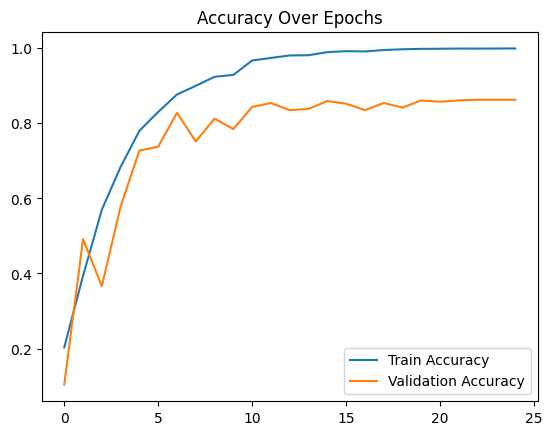

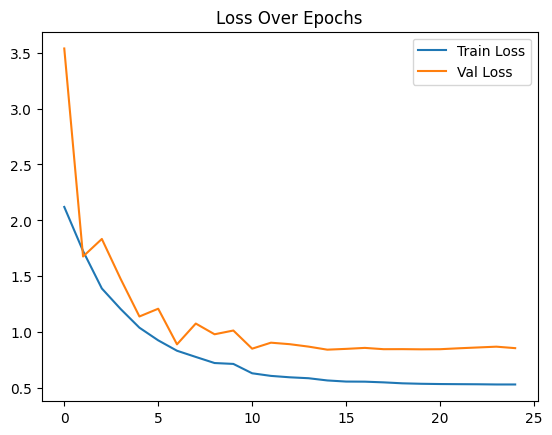

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.5833    0.4667    0.5185        60
           1     0.5469    0.5833    0.5645        60
           2     0.7536    0.8667    0.8062        60
           3     0.9538    0.9394    0.9466        66
           4     1.0000    0.8889    0.9412        54
           5     0.9231    1.0000    0.9600        60
           6     0.9355    0.9667    0.9508        60
           7     0.9062    0.9667    0.9355        60
           8     1.0000    1.0000    1.0000        60
           9     0.9818    0.9000    0.9391        60

    accuracy                         0.8583       600
   macro avg     0.8584    0.8578    0.8562       600
weighted avg     0.8580    0.8583    0.8563       600



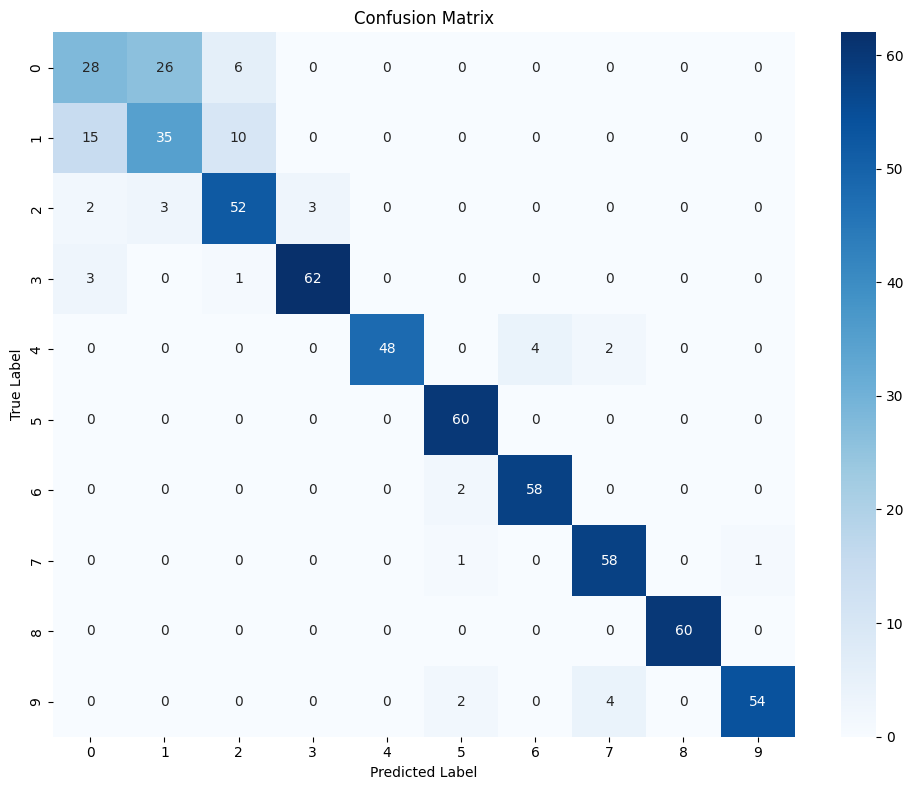

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import gelu
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Softmax, Multiply, Lambda, Reshape

# === 載入資料 ===
train_data = np.load("/content/drive/MyDrive/train_data.npz")
X_train = train_data["X"]
y_train = train_data["y"]

test_data = np.load("/content/drive/MyDrive/test_data.npz")
X_test = test_data["X"]
y_test = test_data["y"]

num_classes = len(np.unique(np.concatenate([y_train, y_test])))

# === 建立 Dataset 生成器 ===
def create_dataset(X, y, batch_size=64, shuffle=True):
    def generator():
        idxs = np.arange(len(X))
        if shuffle:
            np.random.shuffle(idxs)
        for i in idxs:
            yield X[i], to_categorical(y[i], num_classes=num_classes)

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(128, 256, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
        )
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024)
    return dataset.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

train_dataset = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test, shuffle=False)

# === 建立 CNN + BiLSTM 模型 ===
def build_cnn_with_bilstm(input_shape=(128, 256, 1), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    for filters in [32, 64, 128]:
        x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Reshape((-1, x.shape[-1]))(x)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)

    attn_score = Dense(1, activation='tanh')(x)
    attn_weights = Softmax(axis=1)(attn_score)
    x = Multiply()([x, attn_weights])
    x = Lambda(lambda t: tf.reduce_sum(t, axis=1))(x)

    x = Dense(256, activation=gelu)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

model = build_cnn_with_bilstm(num_classes=num_classes)

# === 編譯與訓練模型 ===
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1. - 1e-9)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss_fn


optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

batch_size = 64
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr]
)


# === 繪圖 ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

# === 測試集預測與評估 ===
y_pred_probs = model.predict(X_test, batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()